In [202]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import os
import joblib
from tqdm import tqdm
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm

from audio import Audio

original_metadata_path = os.path.join(".", "data", "original_data_labeled.tsv")
filtered_metadata_path = os.path.join(".", "data", "filtered_data_labeled.tsv")
audio_dir = os.path.join(".", "data", "filtered_clips")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Clean and Load Dataset

Remove records of erroneous data (e.g. missing or corrupted audio files) from the dataset.

In [203]:
if not os.path.exists(filtered_metadata_path):
  df = pd.read_csv(original_metadata_path, sep='\t')

  # Remove unnecessary columns
  df.drop(columns=['client_id', 'sentence', 'age', 'gender', 'accent'], inplace=True, errors='ignore')

  # Filter out rows with missing labels
  df = df[df['label'].notna()]

  with open('error_file_paths.txt', 'r') as f:
      error_file_paths = f.read().splitlines()

  # Convert file paths to just the filename portion
  error_file_paths = [os.path.basename(path) for path in error_file_paths]

  # Remove rows with file paths in the error_file_paths list
  df.drop(df[df['path'].isin(error_file_paths)].index, inplace=True)

  valid_indices = []
  for idx, row in tqdm(df.iterrows(), total=len(df), desc="Checking files"):
    file_path = os.path.join(audio_dir, row['path'])
    if os.path.exists(file_path):
      valid_indices.append(idx)

  # Use only records with existing files
  df = df.loc[valid_indices]

  # Save the filtered DataFrame to a new TSV file
  df.to_csv(filtered_metadata_path, sep='\t', index=False)
else:
  df = pd.read_csv(filtered_metadata_path, sep='\t')

### Visualizations

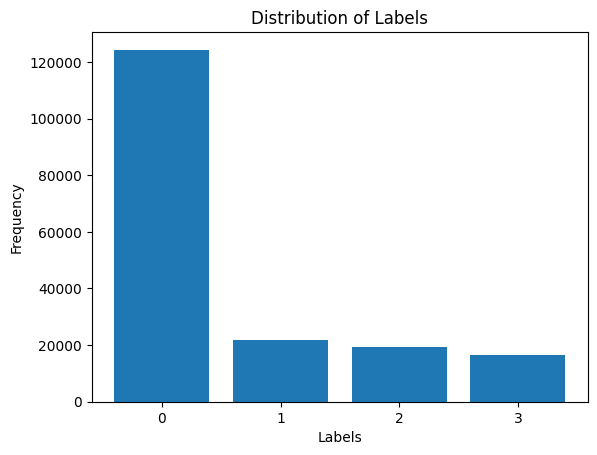

In [204]:
# Get sorted unique labels
labels = sorted(df['label'].unique())

# Define bin edges so bars are centered on labels
bin_edges = np.arange(min(labels) - 0.5, max(labels) + 1.5, 1)

plt.hist(df['label'], bins=bin_edges, rwidth=0.8)
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Labels')
plt.xticks(labels)  # Set ticks to the actual labels
plt.show()

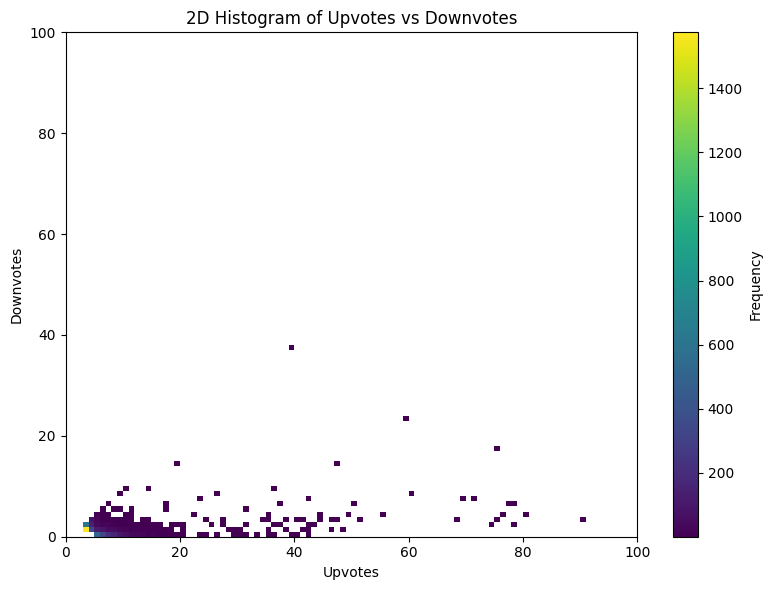

In [205]:
import matplotlib.pyplot as plt

# Create a 2D histogram (heatmap) of upvotes vs downvotes
plt.figure(figsize=(8, 6))
plt.hist2d(df['up_votes'], df['down_votes'], bins=(100, 100), range=[(0, 100), (0, 100)], cmap='viridis', cmin=1, cmax=2000)
plt.colorbar(label='Frequency')

plt.title("2D Histogram of Upvotes vs Downvotes")
plt.xlabel("Upvotes")
plt.ylabel("Downvotes")
plt.tight_layout()

plt.show()

### Loading Training data

In [206]:
samples = 2000 #df['label'].value_counts().min()
balanced_samples = pd.DataFrame()
for cls in range(4): #df['label'].unique():
    cls_df = df[df['label'] == cls]
    sampled = cls_df.sample(n=samples, random_state=42)  # Random sampling
    balanced_samples = pd.concat([balanced_samples, sampled])

### Pipeline

In [207]:
from preprocessing.noise_reduction import NoiseReducer
from preprocessing.silence_removal import SilenceRemover
from preprocessing.dc_removal import DCRemover
from preprocessing.hpf import HPF
from preprocessing.quality_enhancer import QualityEnhancer
from preprocessing.light_loudness_normalization import LightLoudnessNormalizer
from preprocessing.speech_filter import SpeechFilter
from preprocessing.identity import Identity

from feature_extraction.mfcc import MFCC
from feature_extraction.fundamental_frequency import FundamentalFrequency
from feature_extraction.jitter import Jitter
from feature_extraction.hfcc import HFCC
from feature_extraction.cpps import CPPS
from feature_extraction.alpha_ratio import AlphaRatio
from feature_extraction.delta_mfcc import DeltaMFCC
from feature_extraction.pitch_range import PitchRange
from feature_extraction.pitch_range_paper import PitchRange2
from feature_extraction.spectral import SpectralFeatures
from feature_extraction.mean_min_max_frequeny import MeanMinMaxFrequency


In [208]:
noise_reducer = NoiseReducer()
silence_remover = SilenceRemover()
speech_filter = SpeechFilter()
identity = Identity()
dc_remover = DCRemover()
hpf = HPF()
lln = LightLoudnessNormalizer()
silence_remover = SilenceRemover(amplitude_threshold = 0.0005)
quality_enhancer = QualityEnhancer() 

fundamental_freq = FundamentalFrequency()
jitter = Jitter()
alpha_ratio = AlphaRatio()
cpps = CPPS()
hfcc = HFCC()
config = {'n_mfcc': 75, 'n_fft': 2048, 'hop_length': 512, 'context': 3, 
          'use_spectral_subtraction': False, 'use_smoothing': True, 
          'use_cmvn': False, 'use_deltas': True, 'sr': 48000}
mfcc = MFCC(config)
delta_mfcc = DeltaMFCC()
pitch_range = PitchRange()
pitch_range2 = PitchRange2()
spectral = SpectralFeatures()
mean_min_max_freq = MeanMinMaxFrequency()

feature_union = FeatureUnion([
    ('mfcc', mfcc),
    ('hfcc', hfcc),
    ('fundamental_freq', fundamental_freq),
    ('jitter', jitter),
    ('spectral', spectral),
    ('alpha_ratio', alpha_ratio),
    ('cpps', cpps),
    ('pitch_range', pitch_range),
    # ('pitch_range2', pitch_range2),
    # ('delta_mfcc', delta_mfcc),
    ('mean_min_max_freq', mean_min_max_freq),
])

In [209]:
# Sample exactly 48000 points from processed audio
def sample_audio(processed_audio, input_size=48000):

    audio_samples = []
    for processed in processed_audio:
        # Ensure the processed audio is a numpy array
        processed = np.array(processed)
        # Interpolate or truncate to get exactly 48000 samples
        if len(processed) > input_size:
            sampled = processed[:input_size]  # Truncate if longer
        elif len(processed) < input_size:
            sampled = np.interp(
                np.linspace(0, len(processed) - 1, input_size),
                np.arange(len(processed)),
                processed
            )  # Interpolate if shorter
        else:
            sampled = processed  # Already matches input size
        audio_samples.append(sampled)
    return np.array(audio_samples)

In [210]:
def process_in_chunks(df, pipeline, chunk_size=100):
    all_features = []
    all_labels = []

    for i in tqdm(range(0, len(df), chunk_size), desc="Processing chunks"):
        chunk = df.iloc[i:i+chunk_size]
        filenames = chunk['path'].tolist()
        audios = []
        for filename in filenames:
            if "augmented" in filename:
                audio, sr = librosa.load(os.path.join(filename), sr=None)
            else:
                audio, sr = librosa.load(os.path.join(audio_dir, filename), sr=None)
            audios.append(Audio(audio, sr))
        labels = chunk['label'].values

        features = pipeline.transform(audios)
        sampled_audios = sample_audio(features, input_size=48000)
        all_features.append((sampled_audios))
        all_labels.append(labels)

    X = np.concatenate(all_features, axis=0)
    y = np.concatenate(all_labels, axis=0)
    return X, y

In [212]:
# Assuming `audio_samples` is a list of audio samples, each with 48,000 samples
pre_proccessing_pipe = make_pipeline(dc_remover, quality_enhancer, lln, silence_remover, verbose=True)
# Preprocess the audio files in balanced_samples
processed_audio, y = process_in_chunks(balanced_samples, pre_proccessing_pipe, chunk_size=100)



Processing chunks: 100%|██████████| 80/80 [07:23<00:00,  5.55s/it]


In [213]:
print("Shape of processed audio:", len(processed_audio), "x", processed_audio[0].shape)
print("Shape of labels:", y.shape)


Shape of processed audio: 8000 x (48000,)
Shape of labels: (8000,)


In [215]:
X_train, X_val, y_train, y_val = train_test_split(processed_audio, y, test_size=0.2, random_state=42,stratify=y)
print("Shape of training data:", X_train.shape, y_train.shape)
print("Shape of validation data:", X_val.shape, y_val.shape)

Shape of training data: (6400, 48000) (6400,)
Shape of validation data: (1600, 48000) (1600,)


In [211]:
import torch

class NeuralNetwork(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.layer1 = torch.nn.Linear(input_size, hidden_size)
        self.layer2 = torch.nn.Linear(hidden_size, hidden_size)
        self.layer3 = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# Example usage
input_size = 48000
hidden_size = 40
output_size = 48000
model = NeuralNetwork(input_size, hidden_size, output_size)

Training Progress: 100%|██████████| 10/10 [04:45<00:00, 28.60s/it]


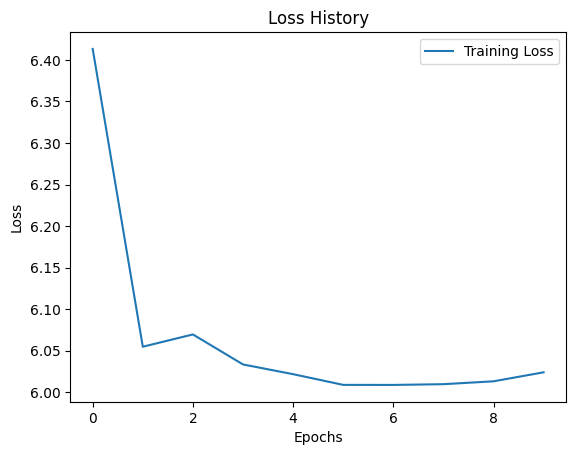

In [216]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Convert audio samples and labels to tensors
X_tensor = torch.tensor(X_train, dtype=torch.float32)
y_tensor = torch.tensor(X_train, dtype=torch.float32)  # Assuming labels are also audio samples

# Create a DataLoader for batching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Define the loss function and optimizer
criterion = torch.nn.MSELoss()  # Mean Squared Error Loss for regression tasks
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in tqdm(range(epochs), desc="Training Progress"):
    model.train()
    total_loss = 0
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        # Save the loss for each batch
    if epoch == 0:
        loss_history = []
    loss_history.append(total_loss)

    # Plot the loss history
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss History')
plt.legend()
plt.show()

In [217]:
# Set the model to evaluation mode
model.eval()

# Initialize variables to track accuracy
correct = 0
total = 0

# Disable gradient computation for testing
with torch.no_grad():
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X)

        # Get predicted labels
        predicted_labels = outputs
        
        # Assuming batch_y contains the true labels
        true_labels = batch_y

        # Update accuracy metrics
        correct += torch.sum(torch.abs(predicted_labels - true_labels) < 0.01).item()/48000
        total += true_labels.size(0)

# Calculate and print accuracy
accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 67.04%


In [218]:
# Create a new model with only the first two layers
class SmallEncoder(torch.nn.Module):
    def __init__(self, original_model):
        super(SmallEncoder, self).__init__()
        self.layer1 = original_model.layer1
        self.layer2 = original_model.layer2

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        return x

# Instantiate the partial model
small_encoder = SmallEncoder(model)


In [219]:
X_train_encoded = small_encoder(torch.tensor(X_train, dtype=torch.float32)).detach().numpy()
X_val_encoded = small_encoder(torch.tensor(X_val, dtype=torch.float32)).detach().numpy()
print(X_train_encoded.shape, X_val_encoded.shape)

(6400, 40) (1600, 40)


In [222]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier as KNN

clf = KNN(n_neighbors=4, n_jobs=-1)

clf.fit(X_train_encoded, y_train)
clf_predictions = clf.predict(X_val_encoded)
cv_scores = [accuracy_score(y_val, clf_predictions)]

# Print cross-validation results
print("Cross-validation scores:", cv_scores)
print("Classification report:\n", classification_report(y_val, clf_predictions))
print("Confusion matrix:\n", confusion_matrix(y_val, clf_predictions))

Cross-validation scores: [0.233125]
Classification report:
               precision    recall  f1-score   support

           0       0.19      0.03      0.05       400
           1       0.14      0.01      0.03       400
           2       0.23      0.81      0.36       400
           3       0.27      0.08      0.12       400

    accuracy                           0.23      1600
   macro avg       0.21      0.23      0.14      1600
weighted avg       0.21      0.23      0.14      1600

Confusion matrix:
 [[ 12   9 362  17]
 [ 16   6 358  20]
 [ 18  11 323  48]
 [ 18  18 332  32]]


In [ ]:
from playsound import playsound

def play_sound(file_path):
    """
    Play a sound file.

    Args:
        file_path (str): Path to the sound file.
    """
    try:
        playsound(file_path)
        playsound(file_path)
    except Exception as e:
        print(f"Error playing sound: {e}")

play_sound("../sound/done.mp3")